# Newton's method using variational equations

In [165]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

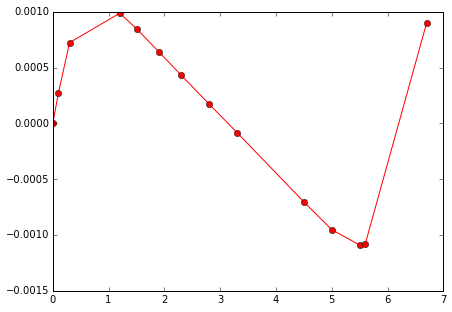

In [199]:
sample_times = np.array([0.,0.1,0.3,1.2,1.5,1.9,2.3,2.8,3.3,4.5,5,5.5,5.6,6.7])
def simple(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.move_to_com()
    samples = np.zeros((len(sample_times)))
    for i,t in enumerate(sample_times):
        sim.integrate(t)
        samples[i] = sim.particles[0].vx
    return samples
x_true = (1.0,0.4)
samples_true = simple(x_true)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
im = ax.plot(sample_times, samples_true, "r-o")

In [257]:
def evaluate(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)

    var_da    = sim.add_variational()
    var_dda   = sim.add_variational(order=2,index_1st_order_a=var_da,index_1st_order_b=var_da)
    var_de    = sim.add_variational()
    var_dde   = sim.add_variational(order=2,index_1st_order_a=var_de,index_1st_order_b=var_de)
    var_da_de = sim.add_variational(order=2,index_1st_order_a=var_da,index_1st_order_b=var_de)
    sim._particles[var_da+1]    = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a")
    sim._particles[var_de+1]    = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="e")
    sim._particles[var_dda+1]   = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a",variation_order=2)
    sim._particles[var_dde+1]   = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="e",variation_order=2)
    sim._particles[var_da_de+1] = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a",variation2="e",variation_order=2)

    sim.move_to_com()
    
    l = 0.
    d = np.zeros((2))
    dd = np.zeros((2,2))
    
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        l += (rv-rvobs)*(rv-rvobs)
        d[0] += 2. * sim.particles[var_da].vx*(rv-rvobs)
        d[1] += 2. * sim.particles[var_de].vx*(rv-rvobs)
        dd[0][0] += 2. * sim.particles[var_dda].vx*(rv-rvobs)
        dd[0][0] += 2. * sim.particles[var_da].vx*sim.particles[var_da].vx
        dd[1][0] += 2. * sim.particles[var_da_de].vx*(rv-rvobs)
        dd[1][0] += 2. * sim.particles[var_da].vx*sim.particles[var_de].vx
        dd[0][1] += 2. * sim.particles[var_da_de].vx*(rv-rvobs)
        dd[0][1] += 2. * sim.particles[var_da].vx*sim.particles[var_de].vx
        dd[1][1] += 2. * sim.particles[var_dde].vx*(rv-rvobs)
        dd[1][1] += 2. * sim.particles[var_de].vx*sim.particles[var_de].vx

    dd[0][1]=0
    dd[1][0]=0.

                     
    return l, d, dd

In [272]:
x = np.array((1.1, 0.2))
N_it = 30
chain = np.zeros((N_it,2))
for i in range(N_it):    
    f, df, ddf = evaluate(x)
    Delta_x = -np.dot(np.linalg.inv(ddf),df)
    #Delta_x = np.array((-df[0]/ddf[0][0],0))
    #Delta_x = - np.array((1./ddf[0][0]*df[0],0))
    #Delta_x = - np.array((0.,1./ddf[1][1]*df[1]))
    chain[i] = ( x)
    
    x = x + 0.25*Delta_x
    
print f

ValueError: Eccentricity must be greater than or equal to zero.

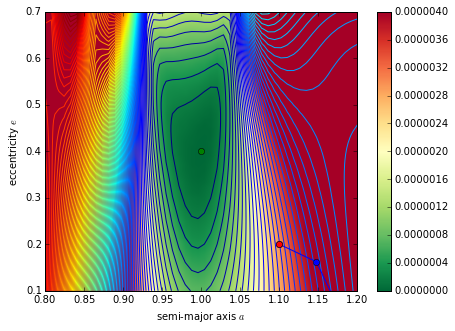

In [273]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(grid_a),max(grid_a),min(grid_e),max(grid_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
im = ax.imshow(grid, cmap="RdYlGn_r", origin="lower", vmin=0., vmax = 0.000004,aspect='auto', extent=extent) #interpolation="none",
ax.contour(grid_a, grid_e, grid,locator=plt.LinearLocator(numticks=100))
ax.plot(chain[:,0],chain[:,1])
ax.plot(chain[:,0],chain[:,1],"ro",color="blue")
ax.plot(x_true[0],x_true[1],"ro",color="green")
ax.plot(chain[0,0],chain[0,1],"ro")
cb = plt.colorbar(im, ax=ax)


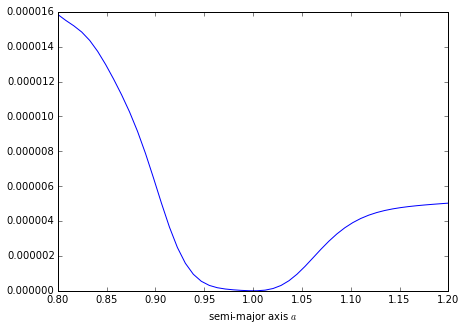

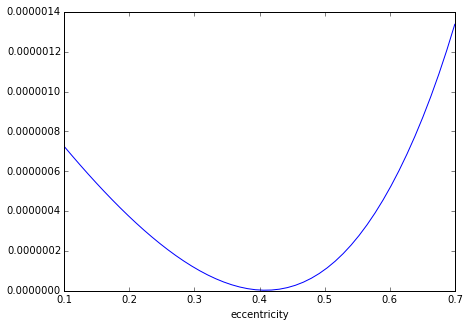

In [254]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.set_xlabel("semi-major axis $a$")
im = ax.plot(grid_a,grid[N/2,:])
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.set_xlabel("eccentricity")
im = ax.plot(grid_e,grid[:,N/2])

In [252]:
def simple_grad(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.move_to_com()
    l = 0.
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        l += (rv-rvobs)*(rv-rvobs)
    return l

In [253]:
N=50
grid = np.zeros((N,N))
grid_a = np.linspace(0.8,1.2,N)
grid_e = np.linspace(0.1,0.7,N)
for i, a in enumerate(grid_a):
    for j, e in enumerate(grid_e):
        l = simple_grad((a,e))
        grid[j][i] = l